In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Loaded: (300, 1024) Labels: (300,)


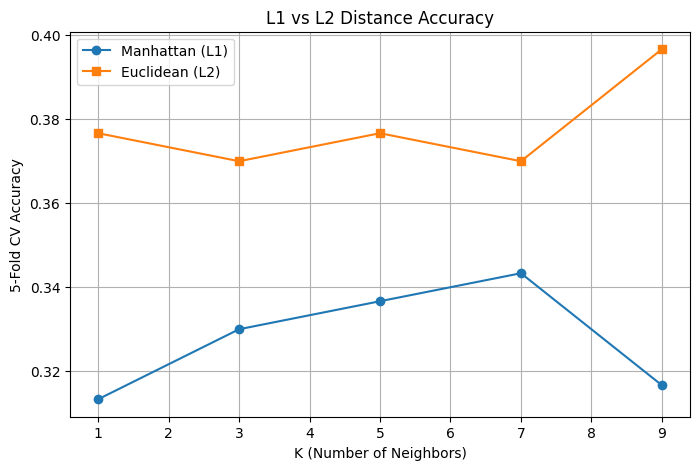

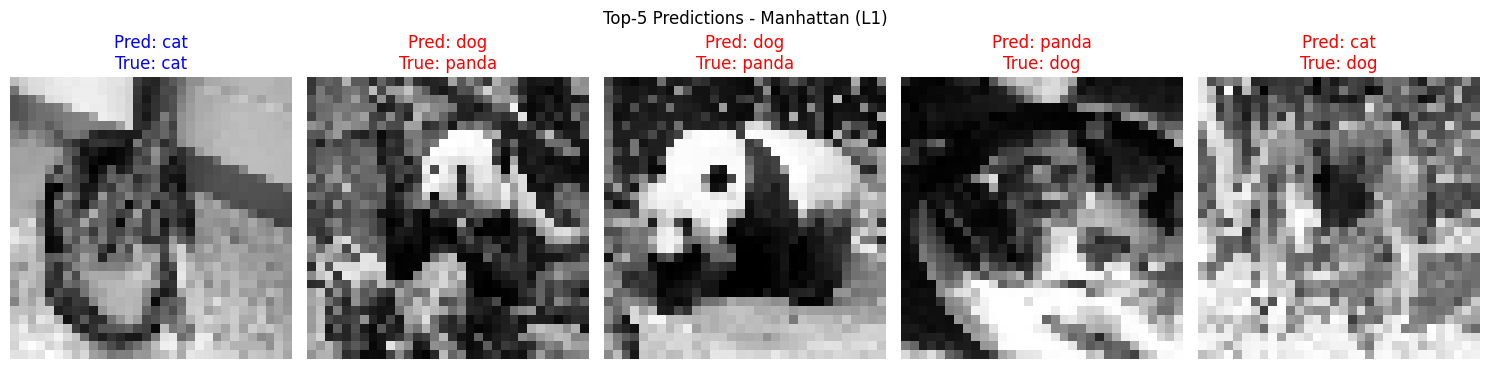

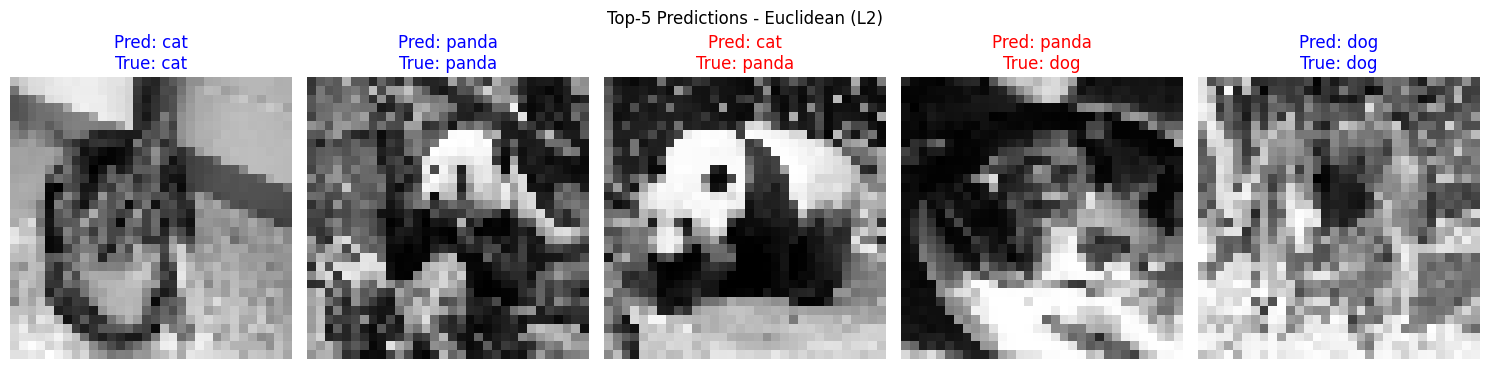

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def load_dataset(dataset_path):
    X, y = [], []
    label_map = {"cat": 0, "dog": 1, "panda": 2}

    for label_name, label_value in label_map.items():
        folder = os.path.join(dataset_path, label_name)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (32, 32))
            X.append(img.flatten())
            y.append(label_value)

    return np.array(X), np.array(y), label_map

dataset_path = "/content/drive/MyDrive/CVPR_Dataset/animal_dataset"
X, y, label_map = load_dataset(dataset_path)
rev_map = {v:k for k,v in label_map.items()}
print("Dataset Loaded:", X.shape, "Labels:", y.shape)


class KNN:
    def __init__(self, K=3, distance='L2'):
        self.K = K
        self.distance = distance

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            if self.distance == 'L1':
                dist = np.sum(np.abs(self.X_train - x), axis=1)
            else:  # L2
                dist = np.sqrt(np.sum((self.X_train - x)**2, axis=1))
            nn_idx = np.argsort(dist)[:self.K]
            nn_labels = self.y_train[nn_idx]
            values, counts = np.unique(nn_labels, return_counts=True)
            y_pred.append(values[np.argmax(counts)])
        return np.array(y_pred)

def manual_cross_val(X, y, K_values, distance):
    n = len(X)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // 5
    scores = []

    for K in K_values:
        fold_acc = []
        for fold in range(5):
            start = fold * fold_size
            end = start + fold_size if fold < 4 else n
            val_idx = indices[start:end]
            train_idx = np.concatenate([indices[:start], indices[end:]])
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]

            knn = KNN(K=K, distance=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            fold_acc.append(np.mean(y_pred == y_val))
        scores.append(np.mean(fold_acc))
    return scores

k_values = [1,3,5,7,9]
l1_scores = manual_cross_val(X, y, k_values, 'L1')
l2_scores = manual_cross_val(X, y, k_values, 'L2')

plt.figure(figsize=(8,5))
plt.plot(k_values, l1_scores, marker='o', label='Manhattan (L1)')
plt.plot(k_values, l2_scores, marker='s', label='Euclidean (L2)')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("5-Fold CV Accuracy")
plt.title("L1 vs L2 Distance Accuracy")
plt.legend()
plt.grid(True)
plt.show()


best_K_L1 = k_values[np.argmax(l1_scores)]
best_K_L2 = k_values[np.argmax(l2_scores)]

knn_l1 = KNN(K=best_K_L1, distance='L1')
knn_l1.fit(X, y)

knn_l2 = KNN(K=best_K_L2, distance='L2')
knn_l2.fit(X, y)


ROWS, COLS = 1, 5
indices = random.sample(range(len(X)), ROWS*COLS)
sample_images = X[indices]
sample_labels = y[indices]

pred_l1 = knn_l1.predict(sample_images)
pred_l2 = knn_l2.predict(sample_images)


def plot_predictions(images, true_labels, pred_labels, title):
    plt.figure(figsize=(15,4))
    for i in range(len(images)):
        img = images[i].reshape(32,32)
        plt.subplot(ROWS, COLS, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        color = 'b' if pred_labels[i] == true_labels[i] else 'r'
        plt.title(f"Pred: {rev_map[pred_labels[i]]}\nTrue: {rev_map[true_labels[i]]}", color=color)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_predictions(sample_images, sample_labels, pred_l1, "Top-5 Predictions - Manhattan (L1)")
plot_predictions(sample_images, sample_labels, pred_l2, "Top-5 Predictions - Euclidean (L2)")
